# Dog Identification App Using Convolutional Neural Networks

---

In this notebook, we make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, this code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

We break the notebook into separate steps.  

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

The required human and dog image datasets are acquired from the following sources:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip)
* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


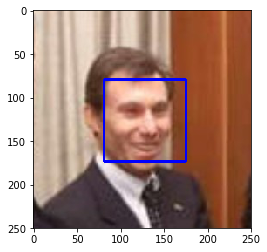

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

We can assess the performance of the human face detector by asking the following questions:
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
true_count_human = 0
true_count_dog = 100

for human_img in human_files_short:
    if face_detector(human_img):
        true_count_human += 1

for dog_img in dog_files_short:
    if not face_detector(dog_img):
        true_count_dog -= 1

print('Percentage of the first 100 images in human_files have a detected human face: {}%'.format(true_count_human))
print('Percentage of the first 100 images in dog_files have a detected human face: {}%'.format(true_count_dog))

Percentage of the first 100 images in human_files have a detected human face: 99%
Percentage of the first 100 images in dog_files have a detected human face: 16%


Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. We can see that our algorithm falls short of this goal, but still gives acceptable performance.  

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

###  Obtain and Use Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

We will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    transform = transforms.Compose([transforms.Resize(size=(244, 244)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img = transform(Image.open(img_path)).unsqueeze(0)
    ## Return the *index* of the predicted class for that image
    prediction = VGG16(img).argmax()
    
    return prediction # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

We use these ideas to create the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = VGG16_predict(img_path)
    if (prediction >= 151) and (prediction <= 268):
        return True
    else:
        return False

### Assess the Dog Detector

We use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [9]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
false_count_dog = 0
true_count_dog = 0

for human_img in human_files_short:
    if dog_detector(human_img):
        false_count_dog += 1

for dog_img in dog_files_short:
    if dog_detector(dog_img):
        true_count_dog += 1
        
print('Percentage of the images in human_files_short have a detected dog: {}%'.format(false_count_dog))
print('Percentage of the images in dog_files_short have a detected dog: {}%'.format(true_count_dog))

Percentage of the images in human_files_short have a detected dog: 0%
Percentage of the images in dog_files_short have a detected dog: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  You will create  CNN _from scratch_, and we must attain a test accuracy of at least 10%.  

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [29]:
import os
from torchvision import datasets

### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20
num_workers = 16

data_dir = 'dogImages/'
dog_files_train = os.path.join(data_dir, 'train/')
dog_files_valid = os.path.join(data_dir, 'valid/')
dog_files_test = os.path.join(data_dir, 'test/')

#---------------------------------------------------------------------------------------------------------------

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

#---------------------------------------------------------------------------------------------------------------

train_data = datasets.ImageFolder(dog_files_train, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(dog_files_valid, transform=data_transforms['val'])
test_data = datasets.ImageFolder(dog_files_test, transform=data_transforms['test'])

#---------------------------------------------------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=num_workers)

loaders_scratch = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader}

In the code above, we applied `RandomResizedCrop` and `RandomHorizontalFlip` only to *train_data*. This will do both image augmentations and resizing jobs. Image augmentation will give randomness to the dataset so, it prevents overfitting and we can expect better performance of model when it is predicting toward test_data. In *valid_data*, we have done Resize of (256) and then, center crop to make 224 X 224. Since valid_data will be used for validation check, we will not do image augmentations. For the *test_data*, we have applied only image resizing.

### Model Architecture

Create a CNN to classify dog breed. 

In [30]:
import torch.nn as nn
import torch.nn.functional as F

num_classes = 133

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 7 * 7 * 128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


In our CNN architecture, the first layer has input shape of (224, 224, 3) and the last layer should output 133 classes. In the first two convolutional layers, we have applied `kernel_size` of 3 with stride 2, which leads to the downsizing of input image by 2. After two convolutional layers, maxpooling with stride 2 is placed, which leads to the downsizing of input image by 2. The 3rd convolutional layer consists of kernel size of 3 with stride 1. This will not reduce input image. After final maxpooling with stride 2, the total output image size is downsized by factor of 32 and the depth will be 128. We have applied dropout of 0.3 in order to prevent overfitting. Fully-connected layer is placed and then, 2nd fully-connected layer is intended to produce final output size, which predicts classes of breeds.

### Specify Loss Function and Optimizer

We use `CrossEntropyLoss` as our loss function and `SGD` as our optimizer.

In [31]:
import torch.optim as optim

### Define loss function
criterion_scratch = nn.CrossEntropyLoss()

### Define optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### Train and Validate the Model

We [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [32]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [33]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.859815 	Validation Loss: 4.768114
Validation loss decreased (inf --> 4.768114).  Saving model ...
Epoch: 2 	Training Loss: 4.716441 	Validation Loss: 4.563173
Validation loss decreased (4.768114 --> 4.563173).  Saving model ...
Epoch: 3 	Training Loss: 4.605209 	Validation Loss: 4.436824
Validation loss decreased (4.563173 --> 4.436824).  Saving model ...
Epoch: 4 	Training Loss: 4.539961 	Validation Loss: 4.362647
Validation loss decreased (4.436824 --> 4.362647).  Saving model ...
Epoch: 5 	Training Loss: 4.500367 	Validation Loss: 4.273098
Validation loss decreased (4.362647 --> 4.273098).  Saving model ...
Epoch: 6 	Training Loss: 4.422770 	Validation Loss: 4.328754
Epoch: 7 	Training Loss: 4.359199 	Validation Loss: 4.202315
Validation loss decreased (4.273098 --> 4.202315).  Saving model ...
Epoch: 8 	Training Loss: 4.316854 	Validation Loss: 4.072584
Validation loss decreased (4.202315 --> 4.072584).  Saving model ...
Epoch: 9 	Training Loss: 4.233963 

In [34]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Test the Model

We try out your model on the test dataset of dog images.  We use the code cell below to calculate and print the test loss and accuracy.  Ensure that our test accuracy is greater than 10%.

In [35]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.773585


Test Accuracy: 12% (101/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Our CNN must attain at least 60% accuracy on the test set.

### Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

In [36]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### Model Architecture

We use transfer learning to create a CNN to classify dog breed.  We use the code cell below, and save our initialized model as the variable `model_transfer`.

In [37]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

n_inputs = model_transfer.fc.in_features
last_layer = nn.Linear(n_inputs, num_classes)

model_transfer.fc = last_layer

for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

As seen in the code cell above, we pick `ResNet` as a transfer model because it performs outstanding on image classification. We look into the structure and functions of `ResNet`. The core idea of ResNet is introducing a so-called “identity shortcut connection” that skips one or more layers. This prevents overfitting when it's training.

The classifier part of the model is a single fully-connected layer:

(fc): Linear(in_features=2048, out_features=1000, bias=True)

This layer is trained on the ImageNet dataset, so it won't work for the dog classification specific problem.
That means we need to replace the classifier (133 classes), but the features will work perfectly on their own.

### Specify Loss Function and Optimizer

We use `CrossEntropyLoss` as our loss function and `SGD` as our optimizer.

In [38]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.05)

### Train and Validate the Model

We train and validate our model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [42]:
# train the model
n_epochs = 1

model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, 
                       use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.384551 	Validation Loss: 0.664052
Validation loss decreased (inf --> 0.664052).  Saving model ...


In [43]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Test the Model

We try out our model on the test dataset of dog images. We use the code cell below to calculate and print the test loss and accuracy.  We need to ensure our test accuracy is greater than 60%.

In [44]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.737304


Test Accuracy: 79% (661/836)


### Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by our model.  

In [47]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(), 
                                    standard_normalization])
    img = transform(Image.open(img_path)).unsqueeze(0)
    ## Return the *index* of the predicted class for that image
    prediction = model_transfer(img).argmax()
    return class_names[prediction]

---
<a id='step5'></a>
## Step 5: Write the Algorithm

We write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [48]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print('A human')
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        print("This person looks like a ...")
        print(predicted_breed.upper())
    elif dog_detector(img_path):
        print('A dog')
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        print("This dog is a ...")
        print(predicted_breed.upper())
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
    print("\n")

---
<a id='step6'></a>
## Step 6: Test the Algorithm

In this section, we will take your new algorithm for a spin.  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test the Algorithm on Sample Images

We test our algorithm on six images.

A human


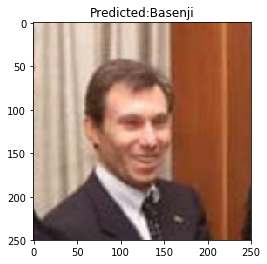

This person looks like a ...
BASENJI


A human


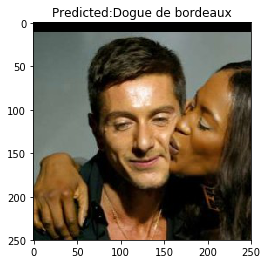

This person looks like a ...
DOGUE DE BORDEAUX


A human


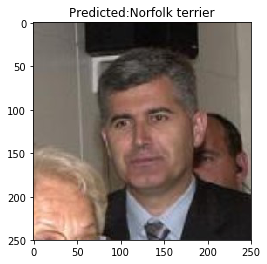

This person looks like a ...
NORFOLK TERRIER


A dog


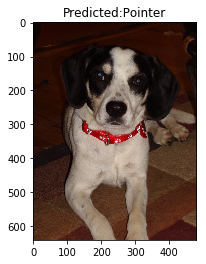

This dog is a ...
POINTER


A dog


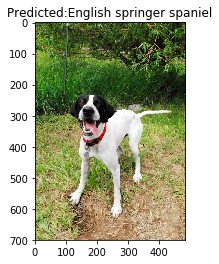

This dog is a ...
ENGLISH SPRINGER SPANIEL


A human


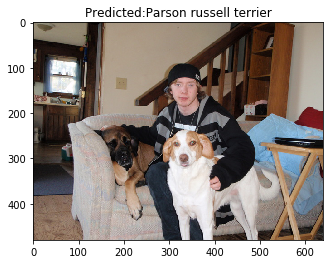

This person looks like a ...
PARSON RUSSELL TERRIER




In [49]:
## Execute our algorithm from Step 6 on 6 images.

for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)